## Forcasting New Daily COVID-19 Vaccinations 

The following notebook uses a previously processed (in the Maven_Processing.ipynb notebook) dataset called "us_series" containing time series information on vaccinations, COVID-19 cases, government restrictions, and mobility in the United States. This data will be processed further as needed in this notebook to prepare for ARIMAX time series modelling. 


In [522]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX # has the capability of arimax
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from statsmodels.nonparametric.smoothers_lowess import lowess
warnings.filterwarnings("ignore")

In [523]:
# Import data set to this notebook
us_series = pd.read_csv("us_series.csv")

In [524]:
# Change date and index to a suitable format for ARIMAX
us_series.index = pd.to_datetime(us_series['date'])
us_series = us_series[~us_series.index.duplicated()]  # just in case there are duplicates
us_series = us_series.reindex(pd.date_range(start=us_series.index.min(), end=us_series.index.max(), freq='D'))

A look at the data: 

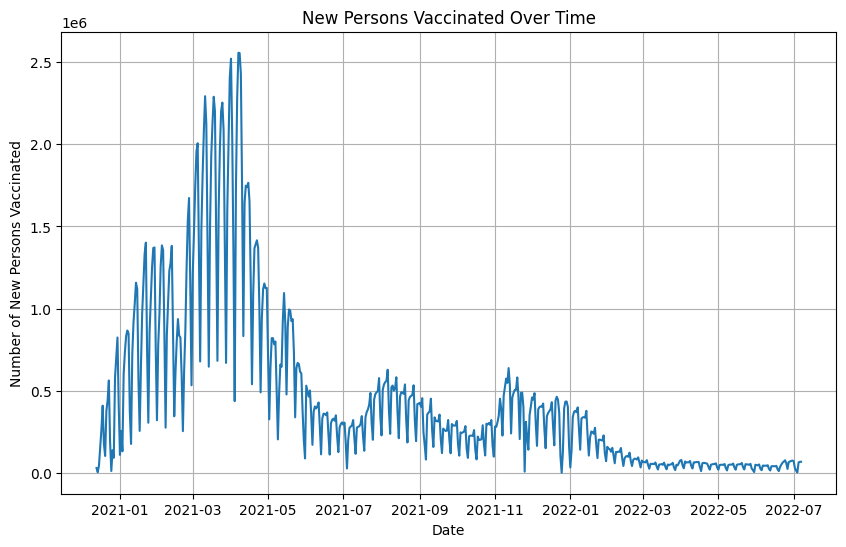

In [525]:
plt.figure(figsize=(10, 6))
plt.plot(us_series['new_persons_vaccinated'])
plt.title('New Persons Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Persons Vaccinated')
plt.grid(True)
plt.show()

I notice that the second have of the data is much different than the early months. This is because COVID-19 began to die down in 2022, leading to much lower vaccination rates. This means that I may want to limit my data to only the part where the vaccine was most prevalent so that this model can be used during times of pandemics. 

I will experiment with different cut-off dates - anywhere from 2021-07 to 2022-01 may be reasonable. For now, I will include data from 2021-01 to 2021-09, but I will experiment with different dates. 

In [526]:
end_date = '2021-11-1' # Subject to change
covid_peak = us_series[:end_date] 

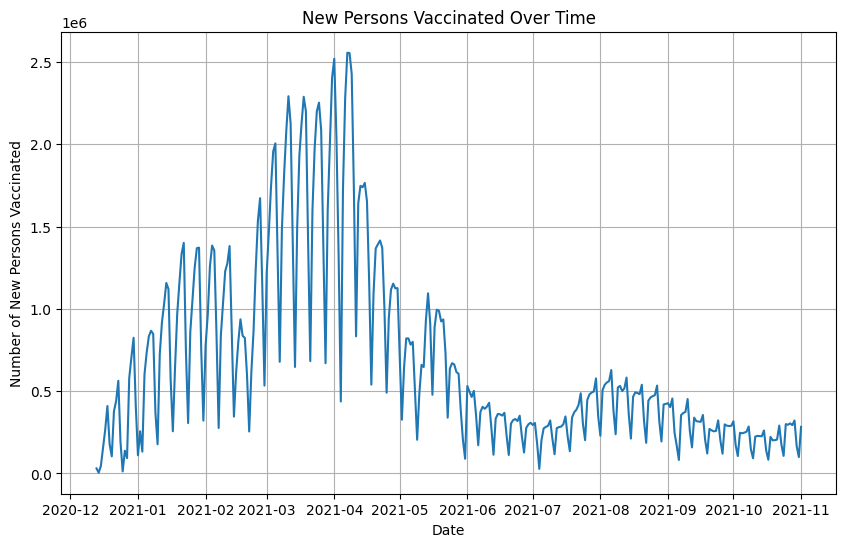

In [527]:
plt.figure(figsize=(10, 6)) 
plt.plot(covid_peak['new_persons_vaccinated'])
plt.title('New Persons Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Persons Vaccinated')
plt.grid(True)
plt.show()

Another thing I notice from the plot is how noisy it is. There is a ton of up and down fluctuation between every data point, which could potentially cloud accuracy the model significantly. I will first attempt to build the model as the data currently is in an attempt to not lose any important information, but I will likely have to apply smoothing techniques later on to reduce the noise of the data. 

Find what variables have a high correlation and could be used in the model:

In [528]:
predictor_columns = ['new_persons_vaccinated', 'new_deceased', 'new_confirmed', 'cumulative_confirmed', 'cumulative_deceased', 
                     'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 
                     'public_transport_closing', 'stay_at_home_requirements', 'restrictions_on_internal_movement', 
                     'international_travel_controls', 'income_support', 'debt_relief', 'fiscal_measures', 
                     'international_support', 'public_information_campaigns', 'testing_policy', 'contact_tracing', 
                     'emergency_investment_in_healthcare', 'investment_in_vaccines', 'facial_coverings', 
                     'vaccination_policy', 'stringency_index', 'mobility_retail_and_recreation', 
                     'mobility_grocery_and_pharmacy', 'mobility_parks', 'mobility_transit_stations', 
                     'mobility_workplaces', 'mobility_residential']

# Calculating correlation matrix
correlation_matrix = covid_peak[predictor_columns].corr()

# Find variables with a correlation above the threshold with the target variable
highly_correlated_vars = correlation_matrix[correlation_matrix['new_persons_vaccinated'].abs() > 0.25]['new_persons_vaccinated']

# Remove the target variable itself from the list
highly_correlated_vars = highly_correlated_vars.drop('new_persons_vaccinated')

# Display the variables with correlations above the threshold
print(f"Variables with correlation above {0.25} with '{'new_persons_vaccinated'}':")
print(highly_correlated_vars)

Variables with correlation above 0.25 with 'new_persons_vaccinated':
cumulative_confirmed        -0.328550
cumulative_deceased         -0.253004
mobility_parks              -0.341512
mobility_transit_stations   -0.360333
mobility_residential         0.315144
Name: new_persons_vaccinated, dtype: float64


The above variables are the predictors to include (as of now) when predicting new_persons_vaccinated
 - except for cumulative variables as those should not be indicative of new vaccinations because cumulative variables onl get larger and don't fluctuate up and down.

In [529]:
exo_vars = ['mobility_parks', 'mobility_transit_stations', 'mobility_residential']
target_var = 'new_persons_vaccinated' # also assign target variable

ARIMAX models can benefit from stationary data (when the statistical properties don't change over time). From a glance, it looks non-stationary, but I will test it using the augmented Dickey-Fuller test.

In [530]:
# Function to check stationarity
def check_stationary(data, var):
    result = adfuller(data[var])
    print(var + ' STATIONARY TEST:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [531]:
# Check stationarity of all variables involved in the model (target and 3 exogenous)
check_stationary(covid_peak, target_var)
check_stationary(covid_peak, exo_vars[0])
check_stationary(covid_peak, exo_vars[1])
check_stationary(covid_peak, exo_vars[2])

new_persons_vaccinated STATIONARY TEST:
ADF Statistic: -1.613789880636535
p-value: 0.47598648953262296
Critical Values: {'1%': -3.4512146067362317, '5%': -2.870730188960711, '10%': -2.5716664849383113}
mobility_parks STATIONARY TEST:
ADF Statistic: -1.387824777592081
p-value: 0.5880989547903268
Critical Values: {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}
mobility_transit_stations STATIONARY TEST:
ADF Statistic: -1.704536878193923
p-value: 0.42877646978703327
Critical Values: {'1%': -3.451621854687657, '5%': -2.870908950689806, '10%': -2.571761810613944}
mobility_residential STATIONARY TEST:
ADF Statistic: -2.2014960658055767
p-value: 0.20570291943010915
Critical Values: {'1%': -3.451621854687657, '5%': -2.870908950689806, '10%': -2.571761810613944}


All variables appear to be at least somewhat non-stationary so they need to be manipulated before performing ARIMAX using the differencing strategy.

In [532]:
# Make a copy of the DataFrame
stationary_data = covid_peak.copy()

# Differencing the target variable
stationary_data['diff_new_persons_vaccinated'] = stationary_data[target_var].diff()
stationary_data = stationary_data.dropna()

# Differencing the exogenous variables
for var in exo_vars:
    stationary_data[f'diff_{var}'] = stationary_data[var].diff()
    stationary_data = stationary_data.dropna()

In [533]:
# Check stationarity again
check_stationary(stationary_data, 'diff_new_persons_vaccinated')
check_stationary(stationary_data, 'diff_mobility_parks')
check_stationary(stationary_data, 'diff_mobility_transit_stations')
check_stationary(stationary_data, 'diff_mobility_residential')

diff_new_persons_vaccinated STATIONARY TEST:
ADF Statistic: -5.95712969627892
p-value: 2.0804186442691693e-07
Critical Values: {'1%': -3.4514162625887037, '5%': -2.8708187088091406, '10%': -2.5717136883095675}
diff_mobility_parks STATIONARY TEST:
ADF Statistic: -6.160479176067392
p-value: 7.194294563922132e-08
Critical Values: {'1%': -3.451973573620699, '5%': -2.8710633193086648, '10%': -2.5718441306100512}
diff_mobility_transit_stations STATIONARY TEST:
ADF Statistic: -6.65970444492824
p-value: 4.8821733670570955e-09
Critical Values: {'1%': -3.4519023023726696, '5%': -2.8710320399170537, '10%': -2.57182745012602}
diff_mobility_residential STATIONARY TEST:
ADF Statistic: -9.003381768034986
p-value: 6.407537735264991e-15
Critical Values: {'1%': -3.4518314994261337, '5%': -2.8710009653519166, '10%': -2.571810878948318}


Now all the p-values are low enough to conclude that the data is stationary, so I will use these variables to run the arimax model.

## ARIMAX Modeling On Stationary Data

It does not make sense to using a typical train/test split on this data because - if i split it 80/20 for example - I will only be testing it on a down trend. Therefore, I will be using cross-validation, which essentially mixes and matches different training/testing sets and repeats over multiple folds to perform a comprehensive model fitting. 

I will experiment with the number of folds as well. 

*Model-Building Notes:*
- Cross-validation trains and tests multiple different folds of data, resulting in different groups of predictions. Therefore, I will get a score (MSE) for each prediction and output that, but also store each prediction so I can make a visualization of all of the predictions vs. the actual vaccination rates. 
- I will be performing a grid-search within the loop to optimize parameters for each fold
    - This will be a nested loop to run on each fold. This may be too computationally expensive, so I may have to revisit this strategy
    - The parameters represent: autoregressive order (p), differencing order (d), moving average order (q)
- I will be saving the best model, and then potentially training it on the full data so that it can be used on future data. 

*Cross Validation Note:*
Time series data is not typically suited for the standard cross validation process considering you should not be predicting current data with data from the future. Therefore, the process will be slightly modified to a process with time-series "splits." I will split the data into folds, like normal, but only train on the data that preceeds that testing set. 

*Source Note*:
My information on how to perform time series cross validation comes from Soumya Shrivastava in her [article](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4) on Medium. 

This fitting process will be made into a function that I can call later with different data or different variables if needed. 

In [606]:
# Function to fit the arimax model with given data and variables
def ARIMAX_fitting(data: pd.DataFrame, target_var: str, exo_vars: list, n_splits: int):

    # Set the ranges 
    p_values = range(0, 4)
    d_values = range(0, 3) # expected to be zero (or at least low) because I already dealt with stationarity
    q_values = range(0, 4)

    # Generate all possible combinations of p, d, q
    param_combinations = list(itertools.product(p_values, d_values, q_values))

    # Create a DataFrame to store the predictions (and fold it came from in case that becomes useful)
    all_predictions = pd.DataFrame(columns=['Fold', 'Date', 'Prediction', 'Lower_CI', 'Upper_CI'])  # confidence interval bounds will likely be useful later
    
    # Initialize variables for storing the best model and best score
    best_model = None
    best_rmse = float('inf')

    tscv = TimeSeriesSplit(n_splits=n_splits) 

    for fold, (train_index, test_index) in enumerate(tscv.split(data)):
        
        # Create the testing and training sets
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        
        # Split further into exogenous variables and target variable for both train_data and test_data
        train_vax_rates, train_exo_vars = train_data[target_var], train_data[exo_vars]
        test_vax_rates, test_exo_vars = test_data[target_var], test_data[exo_vars]

        # Initialize variables for the upcoming loop
        optimized_model = None
        best_aic = float('inf') # infinite because lower AIC is better

        # Nested loop for grid search
        for param in param_combinations:
            model = SARIMAX(train_vax_rates, order=param, exog=train_exo_vars)
            result = model.fit(disp=False) # suppress output

            # Check if this model is the best based on AIC score and save it if so
            if result.aic < best_aic:
                best_params = param  # save parameters to be evaluated later for potential efficiency improvement
                best_aic = result.aic
                optimized_model = result   

        # Make predictions on the test set with the optimized model
        fold_predictions = optimized_model.get_forecast(steps=len(test_vax_rates), exog=test_exo_vars)
        predicted_values = fold_predictions.predicted_mean 
        bounds = fold_predictions.conf_int(alpha=0.05)  # 95% confidence interval bounds

        # Store the dates, predicted values, and confidence interval bounds in the DataFrame
        fold_dates = test_vax_rates.index
        fold_data = pd.DataFrame({
            'Fold': fold,
            'Date': fold_dates,
            'Prediction': predicted_values,
            'Lower_CI': bounds['lower ' + target_var],
            'Upper_CI': bounds['upper ' + target_var]
        })
        # Add data to existing DataFrame
        all_predictions = pd.concat([all_predictions, fold_data], ignore_index=True)

        # Evaluate model performance using root mean squared error
        rmse = sqrt(mean_squared_error(test_vax_rates, predicted_values))

        print("***CURRENT FOLD RESULTS***")
        print(f"Parameters: {best_params}")
        print(f"Root Mean Squared Error: {round(rmse)}")

        # Save the model if it is the best scored so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = result

    return all_predictions, best_model


In [607]:
# Call function with the desired data and variables

target = 'diff_new_persons_vaccinated'
exos = ['diff_mobility_parks', 'diff_mobility_residential', 'diff_mobility_transit_stations']
differenced_predictions, best_differenced_model = ARIMAX_fitting(data=stationary_data, target_var=target, exo_vars=exos, n_splits=12)

***CURRENT FOLD RESULTS***
Parameters: (0, 2, 3)
Root Mean Squared Error: 235588
***CURRENT FOLD RESULTS***
Parameters: (0, 2, 3)
Root Mean Squared Error: 272398
***CURRENT FOLD RESULTS***
Parameters: (1, 2, 3)
Root Mean Squared Error: 563914
***CURRENT FOLD RESULTS***
Parameters: (2, 0, 2)
Root Mean Squared Error: 341106
***CURRENT FOLD RESULTS***
Parameters: (2, 0, 3)
Root Mean Squared Error: 273054
***CURRENT FOLD RESULTS***
Parameters: (2, 0, 3)
Root Mean Squared Error: 313944
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 179398
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 207788
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 94860
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 222618
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 93866
***CURRENT FOLD RESULTS***
Parameters: (3, 0, 2)
Root Mean Squared Error: 79851


Time to investigate the predictions: 

In [608]:
# sort predictions by date
differenced_predictions.sort_values(by=["Date"])
differenced_predictions

,Fold,Date,Prediction,Lower_CI,Upper_CI
0,0,2021-01-18,331315.621786,-130444.132152,793075.375723
1,0,2021-01-19,146102.901795,-354724.975285,646930.778874
2,0,2021-01-20,-55554.038664,-560554.953866,449446.876539
3,0,2021-01-21,38938.016593,-471945.902757,549821.935944
4,0,2021-01-22,140695.995927,-378024.976343,659416.968196
...,...,...,...,...,...
283,11,2021-10-28,19427.042177,-458983.605260,497837.689613
284,11,2021-10-29,4637.284520,-477553.111940,486827.680979
285,11,2021-10-30,-195545.634099,-679550.411344,288459.143147
286,11,2021-10-31,64766.954476,-419260.611108,548794.520060


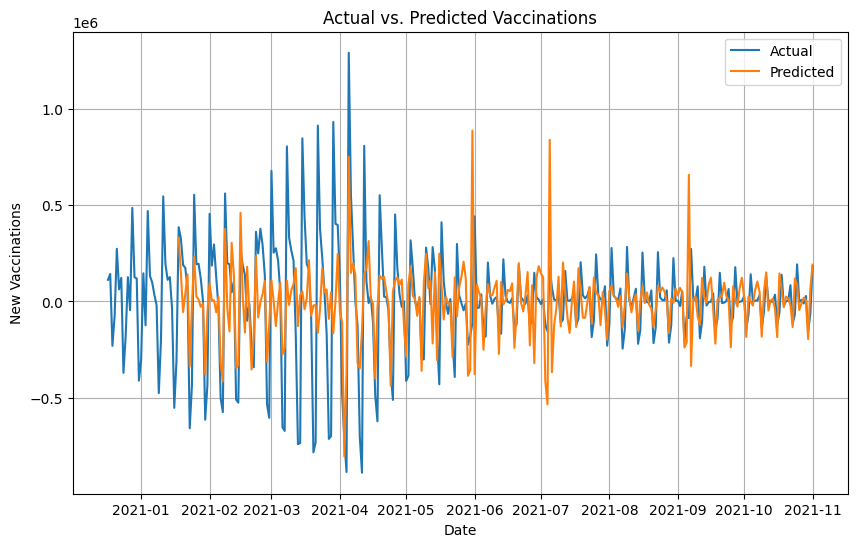

In [626]:
plt.figure(figsize=(10, 6))

# plot the actual vaccinations
plt.plot(stationary_data.index, stationary_data['diff_new_persons_vaccinated'], label = "Actual")
# plot the predicted vaccinations
plt.plot(differenced_predictions["Date"], differenced_predictions['Prediction'], label = "Predicted")

# add labels
plt.xlabel('Date')
plt.ylabel('New Vaccinations')
plt.title('Actual vs. Predicted Vaccinations')
plt.legend()
plt.grid(True)
plt.show()


*Note: The first month or so of data does not have predictions because there was no data before to train a model on and it doesn't make sense to predict on future data. Basically, when making the folds for cros-validation, the first fold is used for training in the first iteration and never gets tested. This will be consistent for all of the actual vs. predicted plots throughout this notebook, unless I cut off the start of the actual values.*

This is a good start, but the noise in the data is making it difficult to interpret. It is also likely difficult for the model to follow the constant up and down nature of the data. Therefore, I will apply lowess (Locally Weighted Scatterplot Smoothing). This basically fits a regression line between intervals of points to smooth the data. 

In [610]:
covid_peak['smoothed_new_persons_vaccinated'] = lowess(covid_peak['new_persons_vaccinated'], range(len(covid_peak['new_persons_vaccinated'])), frac=0.04)[:, 1]

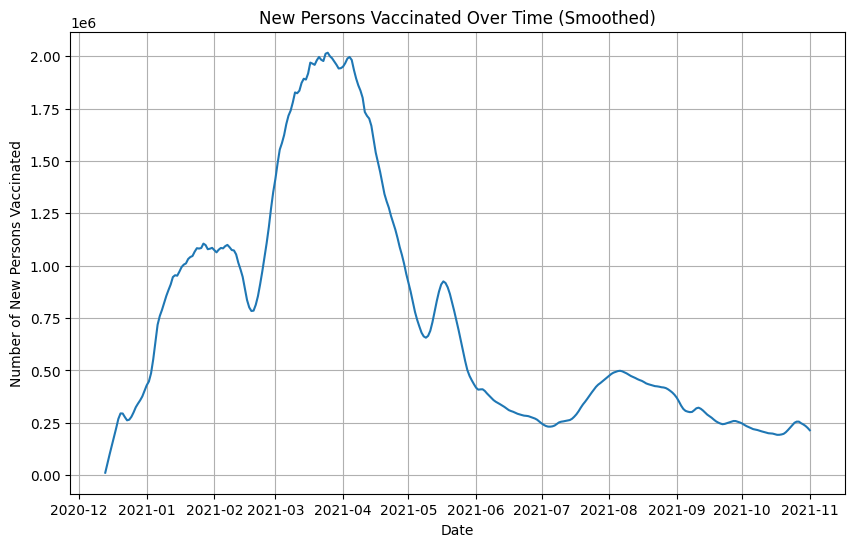

In [611]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(covid_peak['smoothed_new_persons_vaccinated'])
plt.title('New Persons Vaccinated Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Number of New Persons Vaccinated')
plt.grid(True)
plt.show()

This data is a lot less noisy and a lot more clear now. This should improve the interpretability of the model. 

I will now perform the same process, but with this data instead to hopefully see improved results. 


The smoothed data may reveal different correlations, so I will check for those now. 

In [612]:
predictor_columns = ['new_persons_vaccinated', 'new_deceased', 'new_confirmed', 'cumulative_confirmed', 'cumulative_deceased', 
                     'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 
                     'public_transport_closing', 'stay_at_home_requirements', 'restrictions_on_internal_movement', 
                     'international_travel_controls', 'income_support', 'debt_relief', 'fiscal_measures', 
                     'international_support', 'public_information_campaigns', 'testing_policy', 'contact_tracing', 
                     'emergency_investment_in_healthcare', 'investment_in_vaccines', 'facial_coverings', 
                     'vaccination_policy', 'stringency_index', 'mobility_retail_and_recreation', 
                     'mobility_grocery_and_pharmacy', 'mobility_parks', 'mobility_transit_stations', 
                     'mobility_workplaces', 'mobility_residential', 'smoothed_new_persons_vaccinated']

# Calculating correlation matrix
correlation_matrix = covid_peak[predictor_columns].corr()

# Find variables with a correlation above the threshold with the target variable
highly_correlated_vars = correlation_matrix[correlation_matrix['smoothed_new_persons_vaccinated'].abs() > 0.25]['smoothed_new_persons_vaccinated']

# Remove the target variable itself from the list
highly_correlated_vars = highly_correlated_vars.drop('smoothed_new_persons_vaccinated')

# Display the variables with correlations above the threshold
print(f"Variables with correlation above {0.25} with '{'smoothed_new_persons_vaccinated'}':")
print(highly_correlated_vars)

Variables with correlation above 0.25 with 'smoothed_new_persons_vaccinated':
new_persons_vaccinated           0.876712
cumulative_confirmed            -0.382324
cumulative_deceased             -0.298074
mobility_grocery_and_pharmacy   -0.343763
mobility_parks                  -0.357443
mobility_transit_stations       -0.327748
Name: smoothed_new_persons_vaccinated, dtype: float64


These are almost the same variables, except "grocery and pharmacy" has replaced residential. I will now smooth these variables the same way for consistency. 

In [613]:
covid_peak['smoothed_mobility_grocery_and_pharmacy'] = lowess(covid_peak['mobility_grocery_and_pharmacy'], range(len(covid_peak['mobility_grocery_and_pharmacy'])), frac=0.04)[:, 1]
covid_peak['smoothed_mobility_parks'] = lowess(covid_peak['mobility_parks'], range(len(covid_peak['mobility_parks'])), frac=0.04)[:, 1]
covid_peak['smoothed_mobility_transit_stations'] = lowess(covid_peak['mobility_transit_stations'], range(len(covid_peak['mobility_transit_stations'])), frac=0.04)[:, 1]

Since we have new data, I will check the stationarity again using the same process as before, but with the smoothed variables instead. 

In [614]:
# Check stationarity of all variables involved in the model (target and 3 exogenous)
target_var = 'smoothed_new_persons_vaccinated'
exo_vars = ['smoothed_mobility_parks', 'smoothed_mobility_grocery_and_pharmacy', 'smoothed_mobility_transit_stations']
check_stationary(covid_peak, target_var)
check_stationary(covid_peak, exo_vars[0])
check_stationary(covid_peak, exo_vars[1])
check_stationary(covid_peak, exo_vars[2])

smoothed_new_persons_vaccinated STATIONARY TEST:
ADF Statistic: -1.7708672180923992
p-value: 0.39501819009059724
Critical Values: {'1%': -3.4519023023726696, '5%': -2.8710320399170537, '10%': -2.57182745012602}
smoothed_mobility_parks STATIONARY TEST:
ADF Statistic: -1.3383489131057766
p-value: 0.6114502234063783
Critical Values: {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}


smoothed_mobility_grocery_and_pharmacy STATIONARY TEST:
ADF Statistic: -1.6722533062745686
p-value: 0.445462106162051
Critical Values: {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}
smoothed_mobility_transit_stations STATIONARY TEST:
ADF Statistic: -1.0608146683655348
p-value: 0.7304430302980937
Critical Values: {'1%': -3.4519023023726696, '5%': -2.8710320399170537, '10%': -2.57182745012602}


As expected, the values are still non-stationary, so I will do the differencing method again.

*Note:* instead of using "diff_" and "smoothed_" in front of variables (because they will now be both) I will just write "ds_" to indicate that a variable is both differenced and smoothed. 

In [615]:
ds_data = covid_peak.copy()

# Differencing the target variable
ds_data['ds_new_persons_vaccinated'] = ds_data[target_var].diff()
ds_data = ds_data.dropna()

# Differencing the exogenous variables
ds_data['ds_mobility_parks'] = ds_data[exo_vars[0]].diff()
ds_data = ds_data.dropna()
ds_data['ds_mobility_grocery_and_pharmacy'] = ds_data[exo_vars[1]].diff()
ds_data = ds_data.dropna()
ds_data['ds_mobility_transit_stations'] = ds_data[exo_vars[2]].diff()
ds_data = ds_data.dropna()

Now check stationarity again:

In [616]:
# Check stationarity of all variables involved in the model (target and 3 exogenous)
target_var = 'ds_new_persons_vaccinated'
exo_vars = ['ds_mobility_parks', 'ds_mobility_grocery_and_pharmacy', 'ds_mobility_transit_stations']
check_stationary(ds_data, target_var)
check_stationary(ds_data, exo_vars[0])
check_stationary(ds_data, exo_vars[1])
check_stationary(ds_data, exo_vars[2])

ds_new_persons_vaccinated STATIONARY TEST:
ADF Statistic: -2.777791344474086
p-value: 0.06151681126602776
Critical Values: {'1%': -3.4521175397304784, '5%': -2.8711265007266666, '10%': -2.571877823851692}
ds_mobility_parks STATIONARY TEST:
ADF Statistic: -3.112715438814677
p-value: 0.02562638810249357
Critical Values: {'1%': -3.451973573620699, '5%': -2.8710633193086648, '10%': -2.5718441306100512}
ds_mobility_grocery_and_pharmacy STATIONARY TEST:
ADF Statistic: -4.261547328887736
p-value: 0.0005174795223633499
Critical Values: {'1%': -3.451973573620699, '5%': -2.8710633193086648, '10%': -2.5718441306100512}
ds_mobility_transit_stations STATIONARY TEST:
ADF Statistic: -3.051867094119449
p-value: 0.03032643887467847
Critical Values: {'1%': -3.4521175397304784, '5%': -2.8711265007266666, '10%': -2.571877823851692}


This data is mostly stationary now. The target variable is slightly above the 0.05 significance level, but the ARIMAX model parameter "d" is built in to handle some levels of differencing, so I am going to try the model now. 

I will be calling the function previously made, but with the new smoothed and differenced data:

In [617]:
# Call function with the desired data and variables

target = 'ds_new_persons_vaccinated'
exos = ['ds_mobility_parks', 'ds_mobility_grocery_and_pharmacy', 'ds_mobility_transit_stations']
ds_predictions, best_ds_model = ARIMAX_fitting(data=ds_data, target_var=target, exo_vars=exos, n_splits=4)

***CURRENT FOLD RESULTS***
Parameters: (2, 2, 3)
Root Mean Squared Error: 82495
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 3)
Root Mean Squared Error: 43626
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 3)
Root Mean Squared Error: 14446
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 3)
Root Mean Squared Error: 10135


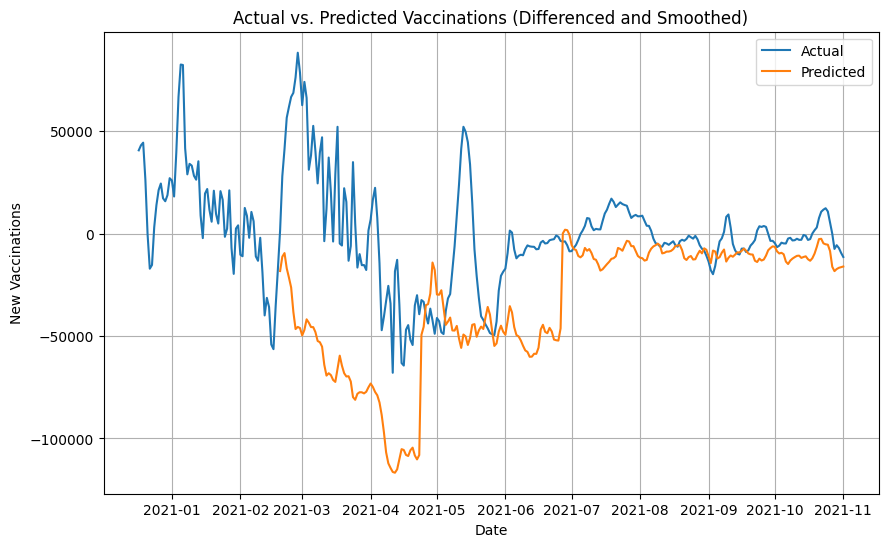

In [618]:
plt.figure(figsize=(10, 6))

# plot the actual vaccinations
plt.plot(ds_data.index, ds_data['ds_new_persons_vaccinated'], label = "Actual")
# plot the predicted vaccinations
plt.plot(ds_predictions["Date"], ds_predictions['Prediction'], label = "Predicted")

# add labels
plt.xlabel('Date')
plt.ylabel('New Vaccinations')
plt.title('Actual vs. Predicted Vaccinations (Differenced and Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

#### To be thorough in finding the best solution, I will do the same thing with just the smoothed data (no differencing applied):

In [619]:
# call function with the desired data and variables

target = 'smoothed_new_persons_vaccinated'
exos = ['smoothed_mobility_parks', 'smoothed_mobility_grocery_and_pharmacy', 'smoothed_mobility_transit_stations']
smoothed_predictions, best_smoothed_model = ARIMAX_fitting(data=ds_data, target_var=target, exo_vars=exos, n_splits=16)

***CURRENT FOLD RESULTS***
Parameters: (2, 2, 3)
Root Mean Squared Error: 134811
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 2)
Root Mean Squared Error: 240937
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 2)
Root Mean Squared Error: 223886
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 3)
Root Mean Squared Error: 60611
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 2)
Root Mean Squared Error: 113423
***CURRENT FOLD RESULTS***
Parameters: (3, 2, 2)
Root Mean Squared Error: 132390
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 514466
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 197651
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 20064
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 112183
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 19762
***CURRENT FOLD RESULTS***
Parameters: (2, 2, 2)
Root Mean Squared Error: 124753
***CURRENT FOLD RESULTS***
Para

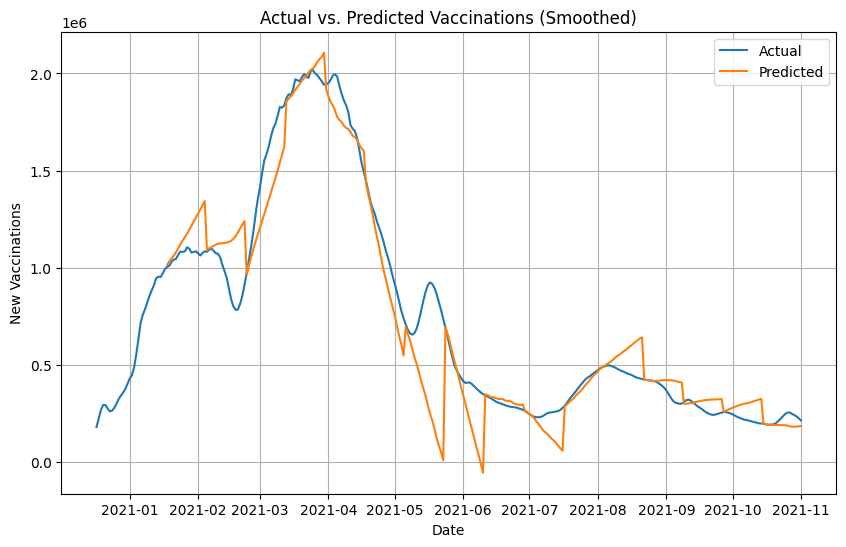

In [620]:
plt.figure(figsize=(10, 6))

# plot the actual vaccinations
plt.plot(ds_data.index, ds_data['smoothed_new_persons_vaccinated'], label = "Actual")
# plot the predicted vaccinations
plt.plot(smoothed_predictions["Date"], smoothed_predictions['Prediction'], label = "Predicted")

# add labels
plt.xlabel('Date')
plt.ylabel('New Vaccinations')
plt.title('Actual vs. Predicted Vaccinations (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

I like these results as they look both more accurate and more interpretable, so I will continue with just the smoothing strategy and no differencing. 

I will now smooth the predictions to match the actual data I am predicting:

In [621]:
smoothed_predictions['s_predictions'] = lowess(smoothed_predictions['Prediction'], range(len(smoothed_predictions['Prediction'])), frac=0.1)[:, 1]

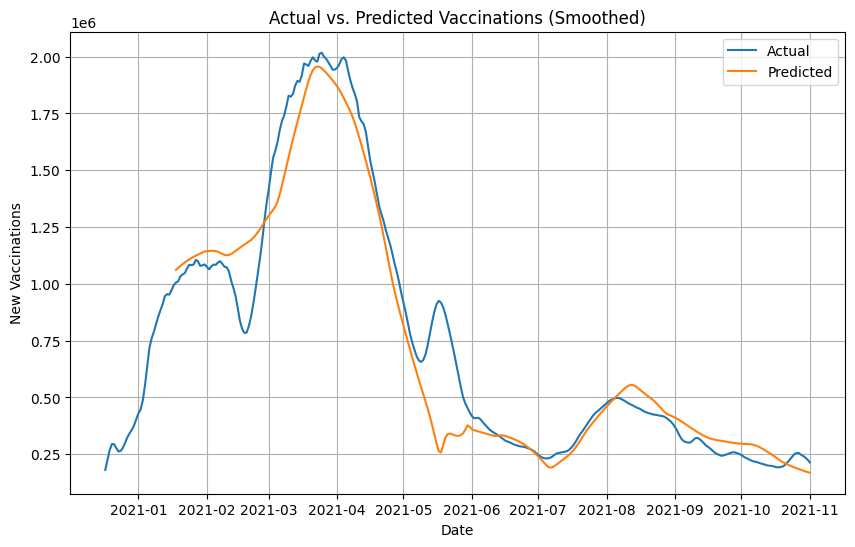

In [622]:
plt.figure(figsize=(10, 6))

# plot the actual vaccinations
plt.plot(ds_data.index, ds_data['smoothed_new_persons_vaccinated'], label = "Actual")
# plot the predicted vaccinations
plt.plot(smoothed_predictions["Date"], smoothed_predictions['s_predictions'], label = "Predicted")

# add labels
plt.xlabel('Date')
plt.ylabel('New Vaccinations')
plt.title('Actual vs. Predicted Vaccinations (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

This looks better now and very interpretable. The predictive model appears to be following the trends well for the most part. I will now get actual scores for the model to evaluate its effectiveness. While I collected root mean squared error for each fold earlier, I would like to calculate the overall statistic, as well as an R^2 to get an idea of how well the model predicts new vaccinations. 

In [623]:
# merge the actual and predicted values so they can match up length-wise (there are actual values at the beginning that don't have predictions)
actual = pd.DataFrame({"Date" : ds_data.index, "Actual" : ds_data['smoothed_new_persons_vaccinated']})
merged = smoothed_predictions.merge(actual, on="Date", how="inner")

In [624]:
actual = merged['Actual'].values
predicted = merged['s_predictions'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Calculate R-squared
r2 = r2_score(actual, predicted)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 150686.6374963627
R-squared: 0.9310588886164354


#### Model Evaluation:
- The R^2 value of 0.93 indicates that approximately 93% of the variance in the actual vaccination rates is explained by my ARIMAX model's predictions, indicating a highly-successful model. This suggests that this ARIMAX model is effective in explaining the observed patterns in daily vaccinations.
- The RMSE, while large in general terms, needs to be interpreted in the context of the scale of the vaccinations. Given that the mean actual value is around 750,000 and can go up to 2 million, an RMSE of 150,686.6 may be considered within an acceptable range.

From examining the Actual vs. Predicted plot and evaluating measurable statistics, I am confident in the explanatory power of the predictions. 

Since the model cannot be expected to be 100% accurate on every prediction, I will construct and 95% confidence interval for each prediction and plot that as well to see how the "prediction range" fits to the actual daily vaccinations. 

#### Final Actual Vs. Predicted Plot With 95% Confidence Interval

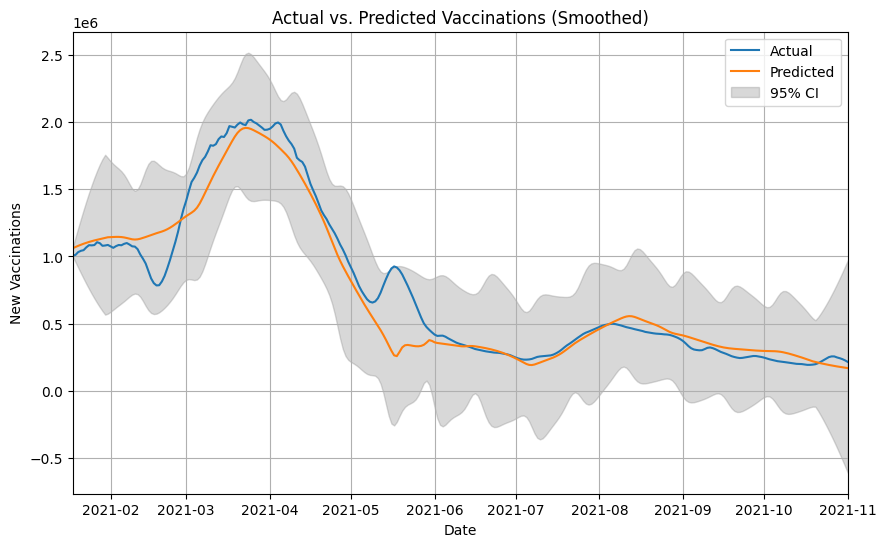

In [660]:
smoothed_predictions['s_Lower_CI'] = lowess(smoothed_predictions['Lower_CI'], range(len(smoothed_predictions['Lower_CI'])), frac=0.09)[:, 1]
smoothed_predictions['s_Upper_CI'] = lowess(smoothed_predictions['Upper_CI'], range(len(smoothed_predictions['Upper_CI'])), frac=0.09)[:, 1]

plt.figure(figsize=(10, 6))

# Plot the actual vaccinations
plt.plot(ds_data.index, ds_data['smoothed_new_persons_vaccinated'], label="Actual")

# Plot the predicted vaccinations
plt.plot(smoothed_predictions["Date"], smoothed_predictions['s_predictions'], label="Predicted")

# Shade the area between the confidence interval bounds
plt.fill_between(smoothed_predictions["Date"],
                 smoothed_predictions['s_Lower_CI'],
                 smoothed_predictions['s_Upper_CI'],
                 color="gray", alpha=0.3, label="95% CI")

# Set x-axis limits to focus on the predicted portion
plt.xlim(smoothed_predictions["Date"].min(), smoothed_predictions["Date"].max())

# Add labels
plt.xlabel('Date')
plt.ylabel('New Vaccinations')
plt.title('Actual vs. Predicted Vaccinations (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

*Note: The confidence interval has been smoothed to enhance clarity in the visualization*

There appears to be no values outside the confidence interval, meaning that the 95% confidence interval for the predictions captures all of the actual new vaccinations for each day. 

*Interpretation:* We are 95% confident that the true amount of new vaccinations in a given day will fall within the predicted bounds from the model fitting and testing. 

## Model Summary
The final model constructed in this notebook leveraged cross-validation with a nested grid search to optimize parameters on each fold, ensuring robust predictive capabilities. The preprocessing stage involved smoothing both the new daily vaccination data and exogenous variables related to mobility, enabling the capture of essential trends. 

Impressively, the model showcased a high R-squared value of 0.93, indicating a 93% explanation of variance. The Root Mean Squared Error (RMSE) was respectively low, given the scale of actual values. A 95% confidence interval was constructed around the predictions, which was able to encompass the entire range of actual new daily vaccinations. This result showcases the model's reliability and represents a powerful tool for anticipating vaccination trends.

## Model Utility:

Healthcare professionals and administrators can leverage this model to guide vaccine distribution and programs. The insights provided by the model can help them get ahead of the trend by efficiently allocating resources and developing strategies to help the community. 

This advanced predictive model holds immense potential in the public health domain. This model-building process can be replicated for healthcare authorities and policymakers to use as a remarkable tool for planning and strategizing vaccination campaigns. The 95% confidence interval provides decision-makers with a clear indication of future vaccination rates, allowing them to make informed decisions that affect our communities. Used appropriately, this can aid in resource allocation, risk assessment, and overall campaign optimization.